## Kaggle - 泰坦尼克号

这是我在做 Kaggle 上 [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic) 任务时的记录，这是一个入门级别的任务，完整地做完后会有不少收获。比如能够学到以下技巧：

1. 缺失数据的处理
2. 数据预处理流程
3. 如何处理取值为连续值的属性
4. 如何处理取值为离散值的属性

另外，还可以实践一下机器学习任务一般流程：

1. 搞清楚问题的定义
2. 获取数据
3. 分析、清洗数据
4. 建模尝试解决这些问题
5. 优化模型，并完成技术报告

In [1]:
# 数据分析
import pandas as pd
import numpy as np
import random as rnd

# 可视化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 获取数据

In [2]:
train = pd.read_csv('./data/titanic/train.csv')

## 观察数据

使用 DataFrame 的`head`，`info`, `describe` 等方法，可以对数据进行宏观的认识。

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


各个字段解释：
    
- PassengerId: 乘客的编号
- Survived: 是否存活
- Pclass: 船舱等级，取值范围 1,2,3
- Name: 姓名
- Sex: 性别
- Age: 年龄
- SibSp: 兄弟姐妹数量
- Parch: 父母和孩子数量
- Ticket: 船票编号
- Fare: 票价
- Cabin: 船舱号
- Embarked: 登船的城市，我想是泰坦尼克号在不同的港口停靠，不同的港口都有乘客登船

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


观察一下数据完整性情况，其中 `Age`, `Cabin`, `Embarked` 存在缺失值。

## 分析数据

样本中 `PassengerId`, `Ticket` 和 `Cabin` 在此处是感觉都没有用的信息，因为虽然船票编号可能决定船舱位置，但已经有相应的字段来说明这些隐含的信息了，所以决定去除这三个字段。



### 各属性的相关程度

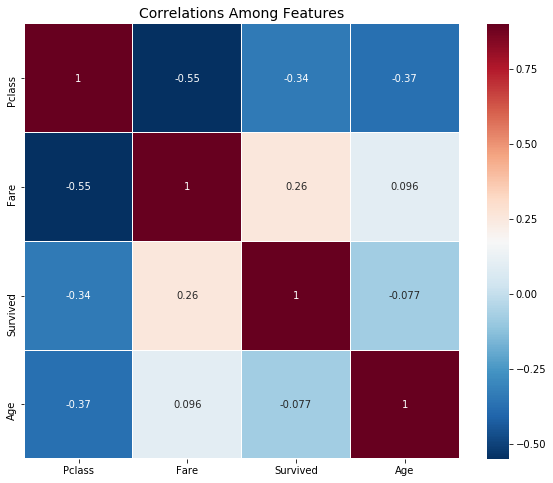

In [6]:
plt.subplots(figsize = (10,8))
sns.heatmap(train[['Pclass', 'Fare', 'Survived', 'Age']].corr(), 
            annot=True,
            #mask = mask,
            cmap = 'RdBu_r',
            linewidths=0.1, 
            linecolor='white',
            vmax = .9,
            square=True)
plt.title("Correlations Among Features", y = 1.03,fontsize = 14);


### Sex 和 Age

性别（Sex）和年龄（Age）应该也会极大地决定是否存活，因为全世界都强调女士优先、小孩老人优先。

In [7]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


因为年龄不适合直接作为特征，可以将年龄划分为不同的范围。可以使用 `pd.cut` 来完成此任务。

使用 `pd.cut` 如果不指定 `label` 得到的结果会是一个范围，这可以让我们看出来各个范围的起始和结束值是多少。可以通过给定 `labels` 参数，明确指出各个段对应的 label。

In [8]:
train['AgeBand'] = pd.cut(train['Age'], 5)
train['AgeBand'].unique()

[(16.336, 32.252], (32.252, 48.168], NaN, (48.168, 64.084], (0.34, 16.336], (64.084, 80.0]]
Categories (5, interval[float64]): [(0.34, 16.336] < (16.336, 32.252] < (32.252, 48.168] < (48.168, 64.084] < (64.084, 80.0]]

将年龄分为 5 个段，并指定标签。

In [9]:
train['AgeBand'] = pd.cut(train['Age'], 5, labels=[1, 2, 3, 4, 5])
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,1,0.550000
1,2,0.369942
2,3,0.404255
3,4,0.434783
4,5,0.090909


### Pclass

船舱等级（Pclass）可取值为：

- 1 (Upper)
- 2 (Middle) 
- 3 (Lower)


船舱等级对幸存与否有很大影响，因为不同收入的人群，受到的待遇不同，船舱的等级可能和距离甲板的距离有关，而距离甲板越近的船舱越有机会逃生。

通过下面生成的统计信息，可以看出船舱等级（Pclass）确实对幸存与否影响很大，不同船舱等级对应的幸存率有明显差异。

In [10]:
train[['Pclass','Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### Fare

从下图中可以看到，票价主要分布在 100 以内，直接使用 `pd.cut` 会将范围划分为：

```
[(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (409.863, 512.329]]
```

这样后面 3 个范围内就没有几个人，因此需要手动指定划分范围。

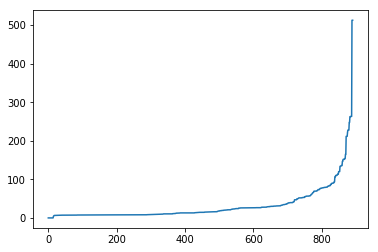

In [13]:
plt.plot(train['Fare'])

使用 `describe()` 方法返回的分位数，可以用于确定各个范围的界。

In [14]:
train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [15]:
train['FareBand'] = pd.cut(train['Fare'], bins=[-np.inf, 7.9, 14.45, 31, np.inf], labels=[1,2,3,4])
train['FareBand'].unique()

[1, 2, 3, 4]
Categories (4, int64): [1 < 2 < 3 < 4]

### Embarked

Embarked 的取值有三种：

- C (Cherbourg) 瑟堡（法国西北部港市）
- Q (Queenstown) 昆斯敦（新西兰）
- S (Southampton) 南安普敦（英国英格兰南部港市）

感觉登船的位置和是否幸存没啥关系，但是统计了一下发现，不同地方登船的乘客，幸存率存在差异。

In [17]:
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


### SibSp 和 Parch

兄弟姐妹数量（SibSp）和父母与孩子数量（Parch）可以统一称为家庭成员数量，由此可以看出一个人是否独自乘船，以及其家庭规模的大小，这都可能影响是否幸存。

In [18]:
train['FamilySize'] = train[['SibSp', 'Parch']].sum(axis=1) + 1
train[["FamilySize", "Survived"]].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [19]:
train['Alone'] = train['FamilySize'] == 1
train[["Alone", "Survived"]].groupby(['Alone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Alone,Survived
0,False,0.505650
1,True,0.303538


## 预处理数据

这包括一下几个步骤：

1. 对缺失值进行填充
2. 添加新的特征，比如是否独自乘船
3. 对连续值，如年龄、票价，进行分段
4. 将枚举值转换为 one-hot 编码的向量

### 使用 `Pipeline` 来做预处理

以上操作可以通过 `sklearn` 提供的 `Pipeline` 一次性搞定。将预处理步骤整合在一起，可以让数据预处理的逻辑更清晰。而且编写的数据预处理逻辑，可以轻松应用到测试数据上。

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes]

class NewFeaturesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['FamilySize'] = X[['SibSp', 'Parch']].sum(axis=1) + 1
        X['Alone'] = X['FamilySize'] == 1
        return X

class SegmentCutter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['AgeBand'] = pd.cut(X["Age"], bins=[0, 16, 32, 48, 64, np.inf],
                              labels=[1, 2, 3, 4, 5])
        X['FareBand'] = pd.cut(X['Fare'], bins=[-np.inf, 7.9, 14.4, 31, np.inf],
                               labels=[1,2,3,4])
        return X

class DataFrameImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy="most_frequent"):
        self.imputer = SimpleImputer(strategy=strategy)
        self.columns = None
        self.index_values = None
    def fit(self, X, y=None):
        self.columns = X.columns
        self.index_values = X.index.values
        
        self.imputer.fit(X)
        return self
    def transform(self, X):
        X = self.imputer.transform(X)
        return pd.DataFrame(X, columns=self.columns, index = list(self.index_values))


attributes = ['Pclass', 'Sex', 'AgeBand', 'Alone', 'FareBand']
    
full_pipeline = Pipeline([
    ('imputer', DataFrameImputer()),
    ('new_features_adder', NewFeaturesAdder()),
    ('segment_cutter', SegmentCutter()),
    ('dataframe_selector', DataFrameSelector(attributes)),
    ('onehot_encoder', OneHotEncoder())
])

### 准备训练数据

In [21]:
# 把训练数据打乱
train = train.reindex(np.random.permutation(train.index))
y_train = train['Survived'].copy()

# 应用 pipeline
X_train = full_pipeline.fit_transform(train)

# 转换为稠密矩阵
X_train = X_train.toarray()

X_train.shape

(891, 16)

## 训练分类器

得到了训练数据之后，就可以开始训练模型了

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

### 随机森林

In [23]:
random_forest = RandomForestClassifier(n_estimators=100)

cross_val_score(random_forest, X_train, y_train, cv=5, scoring='accuracy')

array([0.7877095 , 0.77653631, 0.79213483, 0.7752809 , 0.72881356])

### LogisticRegression

In [24]:
logreg = LogisticRegression(solver='liblinear')

cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

array([0.77094972, 0.77094972, 0.76966292, 0.81460674, 0.75706215])

### 优化模型参数

这里选用随机森林分类器，使用 GridSearch 来搜索最近参数。

In [25]:
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier(n_estimators=100)

param_grid = [
    {
        'max_depth': [2, 3, 4, 5],
        'min_samples_leaf': [1,2,3]
    }
]

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [26]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7946127946127947
{'max_depth': 5, 'min_samples_leaf': 1}


In [27]:
best_model = grid_search.best_estimator_

## 预测

先读取数据，并对测试数据做预处理。预处理环节，可以直接使用上面写好的 pipeline。

In [28]:
test = pd.read_csv('./data/titanic/test.csv')

X_test = full_pipeline.fit_transform(test)

y_pred = best_model.predict(X_test)

保存结果：

In [29]:
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": y_pred
})

submission.to_csv("titanic1_submission.csv", index=False)